<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: 
# image2, assign_wcs

<span style="color:red"> **Instruments Affected**</span>: NIRISS

### Table of Contents
<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Perform Tests](#testing) 
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for the assign_wcs step in the image2 stage of the pipeline. The validation step does two checks: 
1. Round trip conversion between coordinate systems to test whether the output matches the input; 
2. Conversion from sky coordinates to detector coordinates for a catalog of sources to assess whether the originally inputted detector coordinates are recovered.

For more information on the pipeline step visit the links below. 

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html 

> Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

A description of the assign_wcs algorithm from the JWST CalWG: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Imaging+GWCS+Information

[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

GWCS: Generalized World Coordinate System

V1, V2, V3: Defines Observatory Coordinate System (see Figure 1 on [JWST Position Angles, Ranges, and Offsets JDox article](https://jwst-docs.stsci.edu/jwst-observatory-functionality/jwst-position-angles-ranges-and-offsets))

[Top of Page](#title_ID)

<a id="description"></a>
# Test Description
- Calibrate data through Detector1 stage of the pipeline.
- **Round trip conversion test** - check the level of agreement between the input and output values of the following coordinate systems:
    - World --> Detector --> World
    - Detector --> World --> Detector
    - World --> V2 V3 --> World
    - Detector --> V2 V3 --> Detector
- **Round trip conversion test** is done for two sets of input coordinates:
    - Reference pixels at which the transform is anchored:
        - crpix1, crpix2 (detector units)
        - crval1, crval2 (world coordinate system units)
    - Coordinates at the edge of the input subarray:
        - xpix=10, ypix=10
- **Input source catalog test** - use an input list of sources arranged along a grid that have known input detector coordinates from a Mirage simulation. The simulation produces a catalog of sources with world coordinate system units (i.e., RA and Dec). The test converts these coordinates to detector units and checks:
    - The level of agreement between the input and output values;
    - The differences in input and output values with position on the detector.


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description
All data were generated with [MIRaGe](https://github.com/spacetelescope/mirage) version 1.3.3 on date March 10, 2021

**Round trip conversion test**: 10 blank field simulations (spanning a range of RAs) with all available subarray options:
- CLEAR/F200W SUB128
- CLEAR/F200W SUB256
- CLEAR/F200W SUB64
- CLEAR/F200W SUB80
- CLEAR/F200W WFSS128C
- CLEAR/F200W WFSS128R 
- CLEAR/F200W WFSS64C
- CLEAR/F200W WFSS64R
- F480M/NRM FULL
- F480/NRM SUB80

This test also includes the simulation in the below **Input source catalog test**.

**Input source catalog test**: Simulation of a grid of 50 sources with Clear/F200W combination, full frame readout with a grid of 50. MIRaGe catalog (`*_pointsources.list`) is also needed.

Data are stored in temporary directory which is created below.    

[Top of Page](#title_ID)

In [1]:
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    outdir = data_dir.name
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6


In [2]:
# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = True
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

<a id="imports"></a>
# Imports

* astropy.io for opening fits and ascii files
* glob for retrieving fits files
* numpy for mathematical computation
* jwst pipeline steps to process data through stage 1 of the pipeline, use image data model, and access convenience functions in from AssignWcsStep
* matplotlib.pyplot.plt to generate plots

[Top of Page](#title_ID)

In [3]:
from astropy.io import fits,ascii
import glob
import numpy as np
from jwst.pipeline import calwebb_detector1
from jwst.assign_wcs import AssignWcsStep
from jwst.datamodels import image
import matplotlib.pyplot as plt

<a id="data_load"></a>
# Loading the Data

### Data for internal use: Artifactory method
Artifactory should be used for data that is for internal use only.

1. Create a [Jira "Task" Issue in the JWST Simulations Jira project](https://jira.stsci.edu/issues/?jql=project%20%3D%20JWSTSIMS%20AND%20resolution%20%3D%20Unresolved%20ORDER%20BY%20priority%20DESC%2C%20updated%20DESC) requesting to have your data added to Artifactory. Assign the ticket to Misty Cracraft ([@cracraft](https://github.com/cracraft)) or Alicia Canipe ([@aliciacanipe](https://github.com/aliciacanipe)), and provide more information about the data: simulation information, data location, and pipeline step(s). Once your data has been added to Artifactory, Misty Cracraft ([@cracraft](https://github.com/cracraft)) or Alicia Canipe ([@aliciacanipe](https://github.com/aliciacanipe)) will resolve the issue and notify you that your data is ready to be used (the full path to the data will be provided by the person who notified you that your data was ingested successfully).  

2. Make sure you have the proper OS environmental variable set to access STScI's instance of Artifactory. This can be done via command line or put into a setup file like a ```.bash_profile``` file.

```
export TEST_BIGDATA=https://bytesalad.stsci.edu/artifactory/
```

3. Make sure your environment has ```ci_watson``` installed.
```
pip install ci_watson
```

4. In your notebook, import the ```ci_watson``` package needed.

```python
from ci_watson.artifactory_helpers import get_bigdata
```

5. Read in each file stored in Artifactory (the full path should have been provided by the person who ingested the data).

```python
satfile = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'jump',
                                    'jump_miri_test',
                                    'miri_sat_55k.fits')
```

### Data for external use: Box method
Artifactory is only accessible to internal users on the STScI network. If you would like to contribute a test notebook that uses externally available data, this test data should be stored in a Box folder instead. The final workflow using Box is still in discussion, but for now you can use a Box folder with the correct permissions set up:

```python
from astropy.utils.data import download_file

main_box_url ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_ima_tso/"
filename = 'pipetest_miri_imtso_FULL_10g10i_F770W.fits'
file = download_file(mainurl+filename)
```

Box assigns a default alpha-numerical string as the filename, so you may want to update the filename before processing, or verify that the format is correct. Depending on the data, you can try:

```python
# open file into correct format and write to local disk for processing
hdu = fits.open(file)
hdu.info()
hdu.writeto(filename)
```
or use a ```jwst datamodel```:

```python
from jwst.datamodels import RampModel
model = RampModel(file)
model.save(filename)
```

[Top of Page](#title_ID)

In [4]:
# read data from central storage for now
sim_dir = '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'

# grab all simulations in directory
sim_files = glob.glob(os.path.join(sim_dir,'*_nis_uncal.fits*'))

<a id="pipeline"></a>
# Run Detector 1 Stage of the Pipeline 

Run simulations through calwebb_detector1 to produce rate images to test assign_wcs step  

[Top of Page](#title_ID)

In [5]:
# Initialize Detector 1 stage
det1 = calwebb_detector1.Detector1Pipeline()
det1.save_results = True
det1.output_dir = outdir

# Run pipeline on simulations to produce *_rate.fits files
for sfile in sim_files:

    # strip out prefix of file name
    prefix = (sfile.split('uncal')[0]).split('/')[-1]
    det1.output_file = prefix+'rate.fits'

    # Run pipeline

    det1.run(sfile)

2021-05-12 16:12:22,022 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-05-12 16:12:22,025 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-05-12 16:12:22,027 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-05-12 16:12:22,030 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-05-12 16:12:22,032 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-05-12 16:12:22,034 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-05-12 16:12:22,037 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-05-12 16:12:22,039 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-05-12 16:12:22,041 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-05-12 16:12:22,044 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-05-12 1

2021-05-12 16:12:27,712 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.
2021-05-12 16:12:27,755 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-05-12 16:12:27,792 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-05-12 16:12:27,830 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:12:27,832 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:12:27,833 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:12:27,835 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:12:27,871 - stpi

2021-05-12 16:13:12,252 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:13:12,296 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits
2021-05-12 16:13:54,209 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored
2021-05-12 16:13:54,238 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-05-12 16:13:54,273 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-05-12 16:13:54,35

2021-05-12 16:14:23,472 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:14:23,567 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-05-12 16:14:23,568 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:14:23,571 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:14:23,645 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042008001_01101_00001_nis_rateints.fits
2021-05-12 16:14:23,647 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_det

2021-05-12 16:14:23,796 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042005001_01101_00001_nis_rate.fits', 'output_dir': '/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}, 'dq_init': {'pre_h

2021-05-12 16:14:24,374 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:14:24,375 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:14:24,376 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:14:24,377 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:14:24,418 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0122.fits'.
2021-05-12 16:14:24,456 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.
2021-05-12 16:14:24,477 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.
2021-05-12 1

2021-05-12 16:14:26,395 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored
2021-05-12 16:14:26,427 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-05-12 16:14:26,445 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-05-12 16:14:26,520 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:14:26,523 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations

2021-05-12 16:14:35,409 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:14:35,412 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:14:35,483 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042005001_01101_00001_nis_rateints.fits
2021-05-12 16:14:35,485 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-05-12 16:14:35,542 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042005001_01101_00001_nis_rate.fits
2021-05-12 16:14:35,543 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-05-12 16:14:35,599 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data/jw00042007001_01101_00001_nis_uncal.fits.gz',).
2021-05-12 16:14:35,617 - stpipe.Detector1Pipeline - INFO

2021-05-12 16:14:36,129 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.
2021-05-12 16:14:36,149 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.
2021-05-12 16:14:36,178 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits'.
2021-05-12 16:14:36,199 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.
2021-05-12 16:14:36,220 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-05-12 16:14:36,241 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-05-12 16:14:36,262 - stpi

2021-05-12 16:14:38,039 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2021-05-12 16:14:38,093 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:14:38,096 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:14:38,134 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits
2021-05-12 16:14:38,270 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an 

2021-05-12 16:14:46,153 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:14:46,156 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:14:46,216 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:14:46,219 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:14:46,318 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-05-12 16:14:46,319 - stpipe.Detector1Pipeline.gain_scale - INFO - Step wil

2021-05-12 16:14:46,527 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042010001_01101_00001_nis_rate.fits', 'output_dir': '/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}, 'dq_init': {'pre_h

2021-05-12 16:14:47,718 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:14:47,719 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:14:47,720 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:14:47,721 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:14:47,742 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0116.fits'.
2021-05-12 16:14:47,778 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.
2021-05-12 16:14:47,807 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.
2021-05-12 1

2021-05-12 16:14:50,262 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored
2021-05-12 16:14:50,292 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-05-12 16:14:50,335 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-05-12 16:14:50,405 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:14:50,408 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulati

2021-05-12 16:15:14,143 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:15:14,145 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:15:14,232 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042010001_01101_00001_nis_rateints.fits
2021-05-12 16:15:14,234 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-05-12 16:15:14,310 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042010001_01101_00001_nis_rate.fits
2021-05-12 16:15:14,312 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-05-12 16:15:14,378 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data/jw00042004001_01101_00001_nis_uncal.fits.gz',).
2021-05-12 16:15:14,396 - stpipe.Detector1Pipeline - INFO

2021-05-12 16:15:14,789 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.
2021-05-12 16:15:14,810 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.
2021-05-12 16:15:14,830 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits'.
2021-05-12 16:15:14,850 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.
2021-05-12 16:15:14,872 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-05-12 16:15:14,912 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-05-12 16:15:14,940 - stpi

2021-05-12 16:15:16,628 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2021-05-12 16:15:16,690 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:15:16,693 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:15:16,733 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits
2021-05-12 16:15:16,882 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an ex

2021-05-12 16:15:19,135 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:15:19,137 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:15:19,201 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:15:19,204 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:15:19,294 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-05-12 16:15:19,295 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will 

2021-05-12 16:15:19,512 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042001001_01101_00001_nis_rate.fits', 'output_dir': '/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}, 'dq_init': {'pre_h

2021-05-12 16:15:31,230 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:15:31,232 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:15:31,234 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:15:31,235 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:15:31,416 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0029.fits'.
2021-05-12 16:15:31,591 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.
2021-05-12 16:15:31,740 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.
2021-05-12 1

2021-05-12 16:15:44,856 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:15:44,858 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}
2021-05-12 16:15:47,237 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042001001_01101_00001_nis_trapsfilled.fits
2021-05-12 16:15:47,240 - stpipe.Detector1Pipeline.persistence - INFO

2021-05-12 16:18:50,313 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042001001_01101_00001_nis_rate.fits
2021-05-12 16:18:50,314 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-05-12 16:18:50,462 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data/jw00042009001_01101_00001_nis_uncal.fits.gz',).
2021-05-12 16:18:50,478 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042009001_01101_00001_nis_rate.fits', 'output_dir': '/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir'

2021-05-12 16:18:51,477 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.
2021-05-12 16:18:51,517 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-05-12 16:18:51,565 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-05-12 16:18:51,589 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:18:51,590 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:18:51,592 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:18:51,593 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:18:51,635 - stpi

2021-05-12 16:19:31,457 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:19:31,495 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits
2021-05-12 16:20:12,417 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored
2021-05-12 16:20:12,453 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-05-12 16:20:12,489 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-05-12 16:2

2021-05-12 16:20:39,052 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:20:39,055 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:20:39,143 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-05-12 16:20:39,145 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:20:39,147 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:20:39,226 - stpipe.Detector1Pipeline - INFO - Saved model in /var

2021-05-12 16:20:39,380 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042006001_01101_00001_nis_rate.fits', 'output_dir': '/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}, 'dq_init': {'pre_h

2021-05-12 16:20:40,083 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:20:40,084 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:20:40,085 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:20:40,086 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:20:40,121 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0117.fits'.
2021-05-12 16:20:40,161 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.
2021-05-12 16:20:40,181 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.
2021-05-12 1

2021-05-12 16:20:42,076 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored
2021-05-12 16:20:42,108 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-05-12 16:20:42,128 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-05-12 16:20:42,209 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:20:42,212 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulatio

2021-05-12 16:20:45,774 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:20:45,777 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:20:45,844 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042006001_01101_00001_nis_rateints.fits
2021-05-12 16:20:45,845 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-05-12 16:20:45,905 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042006001_01101_00001_nis_rate.fits
2021-05-12 16:20:45,906 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-05-12 16:20:45,969 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data/jw00042003001_01101_00001_nis_uncal.fits.gz',).
2021-05-12 16:20:45,988 - stpipe.Detector1Pipeline - INFO

2021-05-12 16:20:46,327 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.
2021-05-12 16:20:46,348 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.
2021-05-12 16:20:46,373 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits'.
2021-05-12 16:20:46,397 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.
2021-05-12 16:20:46,418 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-05-12 16:20:46,437 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits'.
2021-05-12 16:20:46,480 - stpi

2021-05-12 16:20:48,161 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2021-05-12 16:20:48,225 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 80, 80) from jw00042003001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:20:48,228 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:20:48,262 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits
2021-05-12 16:20:48,414 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an ex

2021-05-12 16:21:00,064 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:21:00,067 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:21:00,132 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 80, 80) from jw00042003001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:21:00,135 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:21:00,231 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-05-12 16:21:00,233 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will 

2021-05-12 16:21:00,447 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042002001_01101_00001_nis_rate.fits', 'output_dir': '/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}, 'dq_init': {'pre_h

2021-05-12 16:21:10,507 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:21:10,508 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:21:10,510 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:21:10,511 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:21:10,530 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0017.fits'.
2021-05-12 16:21:10,570 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.
2021-05-12 16:21:10,594 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.
2021-05-12 1

2021-05-12 16:21:24,417 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:21:24,420 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}
2021-05-12 16:21:26,737 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042002001_01101_00001_nis_trapsfilled.fits
2021-05-12 16:21:26,739 - stpipe.Detector1Pipeline.persistence - INFO

2021-05-12 16:32:12,585 - stpipe.Detector1Pipeline - INFO - Saved model in /var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042002001_01101_00001_nis_rate.fits
2021-05-12 16:32:12,586 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-05-12 16:32:12,731 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data/jw00042011001_01101_00001_nis_uncal.fits.gz',).
2021-05-12 16:32:12,747 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/private/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6/jw00042011001_01101_00001_nis_rate.fits', 'output_dir': '/var/folders/n6/3bl8nljn7yg5_nspzbkc5knh0001wl/T/tmp7eh58bf6', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir'

2021-05-12 16:32:14,025 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.
2021-05-12 16:32:14,063 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-05-12 16:32:14,116 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-05-12 16:32:14,154 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-05-12 16:32:14,155 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-05-12 16:32:14,157 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-05-12 16:32:14,158 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-05-12 16:32:14,201 - stpi

2021-05-12 16:32:53,917 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:32:53,966 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0013.fits
2021-05-12 16:33:40,059 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored
2021-05-12 16:33:40,089 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-05-12 16:33:40,129 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-05-12 16:3

2021-05-12 16:34:16,352 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits.gz>,).
2021-05-12 16:34:16,355 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/lamassa/pipeline_test/assign_wcs/simulations/sim_data'}
2021-05-12 16:34:16,443 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-05-12 16:34:16,445 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-05-12 16:34:16,447 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-05-12 16:34:16,536 - stpipe.Detector1Pipeline - INFO - Saved model in /va

<a id="testing"></a>
# Perform Tests
[Top of Page](#title_ID)

## Round Trip Conversion Test

### Define routines to do the checking

Routine to check whether test passed or failed (is fractional difference between output and input within pre-defined tolerance?)

In [6]:
def ck_pass_fail(in_frac_x,in_frac_y,tol):
    
    if (in_frac_x < tol) & (in_frac_y < tol):
        pass_or_fail = 'PASS'
    else:
        pass_or_fail = 'FAIL'
        
    return(pass_or_fail)

Routine to populate dictionary to store results

In [7]:
def populate_dict(input_dict,obs_info,targ_ra_dec,frac_ra_x,frac_dec_y,conv,pass_or_fail):
    
    input_dict['obs_info'].append(obs_info)
    input_dict['RA_Dec'].append(targ_ra_dec)
    input_dict['frac_ra_x'].append(frac_ra_x)
    input_dict['frac_dec_y'].append(frac_dec_y)
    input_dict['conversion'].append(conv)
    input_dict['pass_fail'].append(pass_or_fail)
    
    return(input_dict)

Routine to transform from World --> Detector --> World coordinates

In [8]:
def world_det_world(in_ra,in_dec,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from RA, Dec to detector coordinates
    det = world_to_detector(in_ra,in_dec)

    # Convert back to RA, Dec
    world = detector_to_world(det[0], det[1])
    
    # Calculate fractional difference between input and output World coordinates
    frac_ra = np.abs((RA-world[0])/RA)
    frac_dec = np.abs((Dec-world[1])/Dec)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_ra,frac_dec,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_ra,frac_dec,conv,pass_or_fail)
    
    # Return dictionary
    return(out_dict)

Routine to transform from Detector --> World --> Detector coordinates

In [9]:
def det_world_det(in_xpix,in_ypix,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from detector coordinates to RA, Dec
    world = detector_to_world(in_xpix, in_ypix)

    # Convert from RA, Dec back to detector
    det = world_to_detector(world[0], world[1])
    
    # Calculate fractional difference between input and output detector coordinates
    frac_x = np.abs((in_xpix-det[0])/in_xpix)
    frac_y = np.abs((in_ypix-det[1])/in_ypix)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_x,frac_y,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_x,frac_y,conv,pass_or_fail)
    
    return(out_dict)

Routine to transform from World --> V2 V3 --> World coordinates

In [10]:
def world_v2v3_world(in_ra,in_dec,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from World coordinates to V2 V3
    v2v3 = world_to_v2v3(RA, Dec)

    # Convert from V2, V3 back to world
    world = v2v3_to_world(v2v3[0], v2v3[1])
    
    # Calculate fractional difference between input and output World coordinates
    frac_ra = np.abs((in_ra-world[0])/in_ra)
    frac_dec = np.abs((in_dec-world[1])/in_dec)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_ra,frac_dec,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_ra,frac_dec,conv,pass_or_fail)
    
    return(out_dict)

Routine to transform from Detector --> V2 V3 --> Detector

In [11]:
def det_v2v3_det(in_xpix,in_ypix,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from detector coordinates to V2 V3
    v2v3 = detector_to_v2v3(in_xpix, in_ypix)

    # Convert from V2, V3 to detector
    det = v2v3_to_detector(v2v3[0], v2v3[1])
    
    # Calculate fractional difference between input and output detector coordinates
    frac_x = np.abs((in_xpix-det[0])/in_xpix)
    frac_y = np.abs((in_ypix-det[1])/in_ypix)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_x,frac_y,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_x,frac_y,conv,pass_or_fail)
    
    return(out_dict)

Routine that checks following conversions for input world and detector coordinates:
* World --> Detector --> World
* Detector --> World --> Detector
* World --> V2 V3 --> World
* Detector --> V2 V3 --> Detector

This routine calls the routines defined above and stores results in dictionary.

In [12]:
def do_all_the_transforms(RA,Dec,xpix,ypix,info_dict,obs_info,targ_ra_dec,pos,tol):
    
    # Check World --> Detector --> World
    info_dict = world_det_world(RA,Dec,info_dict,obs_info,targ_ra_dec,
                                pos+': world --> detector --> world',tol)

    # Check Detector --> World --> Detector
    info_dict = det_world_det(xpix,ypix,info_dict,obs_info,targ_ra_dec,
                             pos+': detector --> world --> detector',tol)

    # Check World --> V2 V3 --> Detector
    info_dict = world_v2v3_world(RA,Dec,info_dict,obs_info,targ_ra_dec,
                                pos+': world --> V2 V3 --> world',tol)

    # Check Detector --> V2 V3 --> Detector
    info_dict = det_v2v3_det(xpix,ypix,info_dict,obs_info,targ_ra_dec,
                             pos+': detector --> V2 V3 --> detector',tol)
    
    return(info_dict)

### Check round trip conversions

In [16]:
# set tolerance for agreement
# use different tolerance for edge of subarray (less accurate)
# and reference pixels (more accurate)
# For the reference pixels, have a stricter tolerance for full frame readou
# which should be more accurate than subarrays
tol_ref_subarray = 1e-3
tol_ref_full = 1e-4
tol_edge = 1e-2

# Initiate AssignWcsStep instance
awcs = AssignWcsStep()

# Select _*rate.fits files
rate_files = glob.glob(os.path.join(outdir,'*rate.fits'))

2021-05-12 16:59:03,826 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


Cycle through simulations to perform conversions and assess agreement between input and output coordinates

In [17]:
# Set up dictionary to store results
info_dict = {'obs_info':[],
             'RA_Dec':[],
             'frac_ra_x':[],
             'frac_dec_y':[],
             'conversion':[],
             'pass_fail':[]}

# Cycle through observations
for r_file in (rate_files):

    # Open image as datamodel
    im = image.ImageModel(r_file)

    # Create observing info string
    exp = im.meta.exposure.type
    filter = im.meta.instrument.filter
    pupil = im.meta.instrument.pupil
    subarray = im.meta.subarray.name
    targ_ra = im.meta.target.ra
    targ_dec = im.meta.target.dec

    obs_info = exp+' '+filter+' '+pupil+' subarray:'+subarray
    targ_ra_dec = 'RA: {}, Dec: {}'.format(targ_ra,targ_dec)

    # Call Assign WCS Step
    gwcs = awcs(im)

    # Set up transforms we'll use:
    world_to_detector = gwcs.meta.wcs.get_transform('world', 'detector')
    detector_to_world = gwcs.meta.wcs.get_transform('detector', 'world')

    world_to_v2v3 = gwcs.meta.wcs.get_transform('world', 'v2v3')
    v2v3_to_world = gwcs.meta.wcs.get_transform('v2v3', 'world')

    detector_to_v2v3 = gwcs.meta.wcs.get_transform('detector','v2v3')
    v2v3_to_detector = gwcs.meta.wcs.get_transform('v2v3','detector')

    # Transform at pixel values close to the edge of the subarray
    xpix = 10
    ypix = 10

    RA,Dec = gwcs.meta.wcs(xpix, ypix)

    # Do the transforms at edge of defined subarray
    info_dict = do_all_the_transforms(RA,Dec,xpix,ypix,info_dict,obs_info,targ_ra_dec,'subarray edge',tol_edge)

    # Transform at reference pixels
    xpix = gwcs.meta.wcsinfo.crpix1
    ypix = gwcs.meta.wcsinfo.crpix2

    RA = gwcs.meta.wcsinfo.crval1
    Dec = gwcs.meta.wcsinfo.crval2

    # Do the transforms at reference pixels
    # Check whether full frame readout or subarray
    if (subarray == 'FULL'):
        tol_ref = tol_ref_full
    else: 
        tol_ref = tol_ref_subarray
    info_dict = do_all_the_transforms(RA,Dec,xpix,ypix,info_dict,obs_info,targ_ra_dec,'reference pixels',tol_ref)

2021-05-12 16:59:15,348 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 64) from jw00042008001_01101_00001_nis_rate.fits>,).
2021-05-12 16:59:15,352 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-05-12 16:59:16,042 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  230.000430024 -1.264540932 230.000802670 -1.227069120 229.999639240 -1.227064291 229.999267089 -1.264535979
2021-05-12 16:59:16,044 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  230.0004300

2021-05-12 16:59:20,560 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-05-12 16:59:21,234 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  350.019764159 -1.250835204 350.020148170 -1.213394270 349.982939197 -1.213179559 349.982567089 -1.250651248
2021-05-12 16:59:21,235 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  350.019764159 -1.250835204 350.020148170 -1.213394270 349.982939197 -1.213179559 349.982567089 -1.250651248
2021-05-12 16:59:21,237 - stpipe.AssignWcsStep - INFO - C

### Pass/Fail test report

In [19]:
# Check whether any observations failed
fail_ind, = np.where(np.array(info_dict['pass_fail']) == 'FAIL')

# if any of the tests failed, print out which observations failed, and by how much
if len(fail_ind > 0):
    print('TEST FAILED for following observations:')
    for i in fail_ind:
        print(info_dict['obs_info'][i])
        print(info_dict['RA_Dec'][i])
        print('Failed test at {}'.format(info_dict['conversion'][i]))
        print('Fractional difference between input & output RA/xpix = {}'.format(info_dict['frac_ra_x'][i]))
        print('Fractional difference between input & output Dec/ypix = {}'.format(info_dict['frac_dec_y'][i]))
        print()
else:
    print('ALL TESTS PASSED - HUZZAH!')
    print('\nFractional differences between input & output coordinates were all '\
          'within pre-defined tolerances of:')
    print('{} (reference pixels, full frame), {} (reference pixels, subarray) or {} (edge of subarray)'.
          format(tol_ref_full, tol_ref_subarray, tol_edge))    

ALL TESTS PASSED - HUZZAH!

Fractional differences between input & output coordinates were all within pre-defined tolerances of:
0.0001 (reference pixels, full frame), 0.001 (reference pixels, subarray) or 0.01 (edge of subarray)


#### Run cell below if interested in seeing the fractional differences between input and output coordinates for all observations

In [20]:
for i in range(len(info_dict['obs_info'])):
    print(info_dict['obs_info'][i])
    print(info_dict['RA_Dec'][i])
    print('Test at {}: {}'.format(info_dict['conversion'][i],info_dict['pass_fail'][i]))
    print('Fractional difference between input & output RA/xpix = {}'.format(info_dict['frac_ra_x'][i]))
    print('Fractional difference between input & output Dec/ypix = {}'.format(info_dict['frac_dec_y'][i]))
    print()

NIS_IMAGE CLEAR F200W subarray:WFSS64R
RA: 230.0, Dec: -1.25
Test at subarray edge: world --> detector --> world: PASS
Fractional difference between input & output RA/xpix = 1.72935780909149e-10
Fractional difference between input & output Dec/ypix = 6.108352506395415e-08

NIS_IMAGE CLEAR F200W subarray:WFSS64R
RA: 230.0, Dec: -1.25
Test at subarray edge: detector --> world --> detector: PASS
Fractional difference between input & output RA/xpix = 0.00022294721220532664
Fractional difference between input & output Dec/ypix = 0.0004219931016677947

NIS_IMAGE CLEAR F200W subarray:WFSS64R
RA: 230.0, Dec: -1.25
Test at subarray edge: world --> V2 V3 --> world: PASS
Fractional difference between input & output RA/xpix = 0.0
Fractional difference between input & output Dec/ypix = 0.0

NIS_IMAGE CLEAR F200W subarray:WFSS64R
RA: 230.0, Dec: -1.25
Test at subarray edge: detector --> V2 V3 --> detector: PASS
Fractional difference between input & output RA/xpix = 0.00022294707764558552
Fractional 

NIS_IMAGE CLEAR F200W subarray:SUB80
RA: 305.0, Dec: -1.25
Test at reference pixels: world --> V2 V3 --> world: PASS
Fractional difference between input & output RA/xpix = 0.0
Fractional difference between input & output Dec/ypix = 3.552713622109576e-16

NIS_IMAGE CLEAR F200W subarray:SUB80
RA: 305.0, Dec: -1.25
Test at reference pixels: detector --> V2 V3 --> detector: PASS
Fractional difference between input & output RA/xpix = 0.00015630131868558396
Fractional difference between input & output Dec/ypix = 3.781174900834186e-05

NIS_IMAGE F480M NRM subarray:SUB80
RA: 335.0, Dec: -1.25
Test at subarray edge: world --> detector --> world: PASS
Fractional difference between input & output RA/xpix = 4.3624866359928163e-10
Fractional difference between input & output Dec/ypix = 1.7417071246034308e-08

NIS_IMAGE F480M NRM subarray:SUB80
RA: 335.0, Dec: -1.25
Test at subarray edge: detector --> world --> detector: PASS
Fractional difference between input & output RA/xpix = 0.00080322577005063

Fractional difference between input & output RA/xpix = 2.250146736193387e-10
Fractional difference between input & output Dec/ypix = 1.6239342951193135e-07

NIS_IMAGE CLEAR F200W subarray:SUB64
RA: 320.0, Dec: -1.25
Test at reference pixels: detector --> world --> detector: PASS
Fractional difference between input & output RA/xpix = 0.00011790444990625615
Fractional difference between input & output Dec/ypix = 0.00034192862084847335

NIS_IMAGE CLEAR F200W subarray:SUB64
RA: 320.0, Dec: -1.25
Test at reference pixels: world --> V2 V3 --> world: PASS
Fractional difference between input & output RA/xpix = 0.0
Fractional difference between input & output Dec/ypix = 1.7763566485828141e-16

NIS_IMAGE CLEAR F200W subarray:SUB64
RA: 320.0, Dec: -1.25
Test at reference pixels: detector --> V2 V3 --> detector: PASS
Fractional difference between input & output RA/xpix = 0.00011790440101741787
Fractional difference between input & output Dec/ypix = 0.0003419286201628543

NIS_IMAGE CLEAR F200W suba

## Input Source Catalog Test
[Top of Page](#title_ID)

### Routine for plotting image to visualize sources on detector

In [28]:
def show_image(image, min=0, max=1.5, plt_srcs=False, **kwargs):
    
    plt.figure(figsize=(12,12))
    plt.imshow(image, clim=(min, max))
    
    if (plt_srcs):
        
        x_pix = kwargs['x_pix']
        y_pix = kwargs['y_pix']

        box_size = 20
                    
        # plot box around each source
        for i in range(len(x_pix)):
            plt.plot([x_pix[i] - box_size, x_pix[i] + box_size],
                     [y_pix[i] + box_size, y_pix[i] + box_size], 
                     color='white', lw=3)   
            plt.plot([x_pix[i] - box_size, x_pix[i] + box_size],
                     [y_pix[i] - box_size, y_pix[i] - box_size], 
                     color='white', lw=3)
            plt.plot([x_pix[i] - box_size, x_pix[i] - box_size],
                     [y_pix[i] - box_size, y_pix[i] + box_size], 
                     color='white', lw=3)
            plt.plot([x_pix[i] + box_size, x_pix[i] + box_size],
                     [y_pix[i] - box_size, y_pix[i] + box_size], 
                     color='white', lw=3)
            
    plt.show()

### Check difference between output and input pixel coordinates
Read in simulated image and input source catalog from MIRaGe

In [29]:
# set up tolerance
tol_pix_diff = 0.01

rate_img = os.path.join(outdir,'jw00042001001_01101_00001_nis_rate.fits')

# Save image as data model
image_dm = image.ImageModel(rate_img)

# Initialize AssignWcsStep
awcs = AssignWcsStep()
gwcs = awcs(image_dm)

# read MIRaGe's point source list
ptsrc_list_f = os.path.join(sim_dir,
                            'sim_assign_wcs_50ptsrc_field_CLEAR_F200W_FULL_pointsources.list')
ptsrc_list = ascii.read(ptsrc_list_f, header_start=2)

# See column names of input source catalog
print(ptsrc_list.colnames)

2021-05-12 17:02:59,341 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-05-12 17:02:59,431 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw00042001001_01101_00001_nis_rate.fits>,).
2021-05-12 17:02:59,434 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-05-12 17:03:00,240 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  20.018394864 1.231182785 20.018777102 1.268623738 19.981567336 1.268836167 19.981198056 1.231364450
2021-05-12 17:03:00,242 - stpi

['Index', 'RA_(hh:mm:ss)', 'DEC_(dd:mm:ss)', 'RA_degrees', 'DEC_degrees', 'pixel_x', 'pixel_y', 'magnitude', 'counts/sec', 'counts/frame', 'TSO_lightcurve_catalog']


Show calibrated image and where sources fell

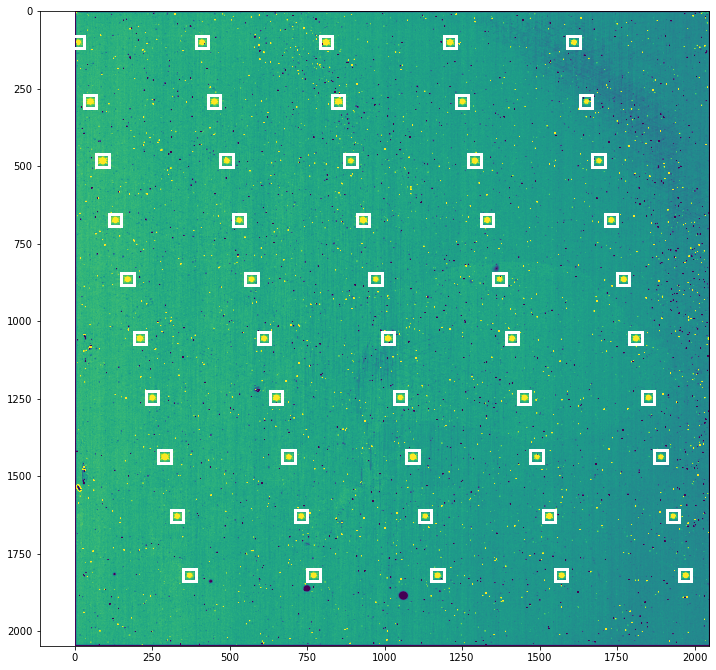

In [30]:
# Display image

show_image(image_dm.data,plt_srcs=True, x_pix=ptsrc_list['pixel_x'], y_pix=ptsrc_list['pixel_y'])

Convert from World to detector coordinates and compare with input detector coordinates

In [31]:
world_to_detector = gwcs.meta.wcs.get_transform('world', 'detector')

det = world_to_detector(ptsrc_list['RA_degrees'], ptsrc_list['DEC_degrees'])

del_x = det[0] - ptsrc_list['pixel_x']
del_y = det[1] - ptsrc_list['pixel_y']

del_x_rms = np.sqrt(np.mean(del_x**2))
del_y_rms = np.sqrt(np.mean(del_y**2))

print('RMS of delta-x is {0:.4f} and RMS of delta-Dy is {1:.4f}'.format(
del_x_rms, del_y_rms))

RMS of delta-x is 0.0057 and RMS of delta-Dy is 0.0047


Plot distribution of $\Delta$x and $\Delta$y

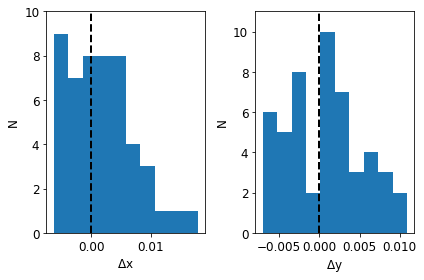

In [32]:
# Set up plot
fig,(ax1, ax2) = plt.subplots(1,2)

# Plot delta-x histogram
x_hist = ax1.hist(del_x)
# Label plot
ax1.set_xlabel(r'$\Delta$x',fontsize=12)
ax1.set_ylabel('N',fontsize=12)
# Set plot limits
ax1_yup = np.max(x_hist[0]) + 1
ax1.set_ylim(0, ax1_yup)
# plot line at zero
ax1.plot([0,0],[0,ax1_yup], '--', lw=2, c='black')
ax1.tick_params(labelsize=12)

# Plot delta-Dec histogram
y_hist = ax2.hist(del_y)
# Label plot
ax2.set_xlabel(r'$\Delta$y',fontsize=12)
ax2.set_ylabel('N',fontsize=12)
# Set plot limits
ax2_yup = np.max(y_hist[0]) + 1
ax2.set_ylim(0, ax2_yup)
# plot line at zero
ax2.plot([0,0],[0,ax2_yup], '--', lw=2, c='black')
ax2.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

Plot $\Delta$x and $\Delta$y as function of inputted x and y. Symbol & color-code based on detector position.

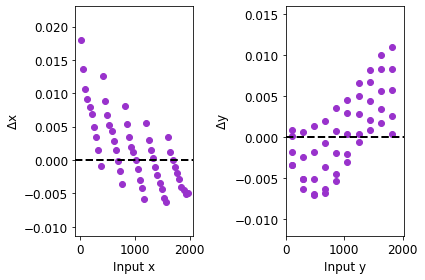

In [33]:
# Set up plot
fig,(ax1, ax2) = plt.subplots(1,2)

# Plot delta-x as function of input x
ax1.scatter(ptsrc_list['pixel_x'], del_x, marker='o', color='darkorchid')

# Label plot
ax1.set_ylabel(r'$\Delta$x',fontsize=12)
ax1.set_xlabel('Input x',fontsize=12)
# Set bounds on plot
xlo = np.min(ptsrc_list['pixel_x']) - 100
xhi = np.max(ptsrc_list['pixel_x']) + 100
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(np.min(del_x) - 0.005,
             np.max(del_x) + 0.005)

# Plot horizontal line at 0
ax1.plot([xlo, xhi],[0,0], '--', lw=2, color='black')
ax1.tick_params(labelsize=12)


# Plot delta-y as function of input y
ax2.scatter(ptsrc_list['pixel_y'], del_y, marker='o', color='darkorchid')

# Label plot
ax2.set_ylabel(r'$\Delta$y',fontsize=12)
ax2.set_xlabel('Input y',fontsize=12)
# Set bounds on plot
xlo = np.min(ptsrc_list['pixel_y'])-100
xhi = np.max(ptsrc_list['pixel_y'])+200
ax2.set_xlim(xlo, xhi)
ax2.set_ylim(np.min(del_y)-0.005,np.max(del_y)+0.005)
# Plot horizontal line at 0
ax2.plot([xlo, xhi],[0,0], '--', lw=2, color='black')
ax2.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### Pass/Fail test report

In [40]:
if ( ((del_x_rms) < tol_pix_diff) &
     ((del_y_rms) < tol_pix_diff)):
    print('Test passed! HUZZAH!')
else:
    print('TEST FAILED') 

print()
print('Tolerance for RMS of delta-x and delta-y is {}\n'.format(tol_pix_diff))
print('RMS of Del-x is: {0:0.4f},\nmaximum del-x: {1:0.4f}, \nminimum del-x: {2:0.5f}'.format(
    del_x_rms, np.max(abs(del_x)), np.min(abs(del_x))))
print('\nRMS of Del-y is: {0:0.4f}, \nmaximum of del-y of {1:0.4f}, \nminium del-y: {2:0.5f}'.format(
    del_y_rms, np.max(abs(del_y)), np.min(abs(del_y))))

Test passed! HUZZAH!

Tolerance for RMS of delta-x and delta-y is 0.01

RMS of Del-x is: 0.0057,
maximum del-x: 0.0180, 
minimum del-x: 0.00002

RMS of Del-y is: 0.0047, 
maximum of del-y of 0.0109, 
minium del-y: 0.00014


<a id="about_ID"></a>
## About this Notebook
**Author:** S. LaMassa, NIRISS
<br>**Updated On:** MM/DD/YYYY

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 